In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import pickle

Make synthetic data

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=5000, n_features=40, n_informative=3,
    n_redundant=2, n_repeated=0, n_classes=2,
    n_clusters_per_class=3, weights=None, flip_y=0.05,
    class_sep=0.1, hypercube=True, shift=0.0,
    scale=1.0, shuffle=True, random_state=2)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
train_test_split(X, y, test_size=0.2, random_state=24)

In [4]:
eval_set = [(X_train, y_train), (X_val, y_val)]

In [5]:
y.mean()

0.4986

# `lossguide` tree growing

In [6]:
xgb_model_3 = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=0,
    learning_rate=0.1,
    verbosity=1,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    tree_method='hist',
    grow_policy='lossguide')

In [7]:
max_leaves_values = list(range(5,105,5))
print(max_leaves_values[:5])
print(max_leaves_values[-5:])

[5, 10, 15, 20, 25]
[80, 85, 90, 95, 100]


In [8]:
%%time
val_aucs = []
for max_leaves in max_leaves_values:
    #Set parameter and fit model
    xgb_model_3.set_params(**{'max_leaves':max_leaves})
    xgb_model_3.fit(X_train, y_train, eval_set=eval_set,
                  eval_metric='auc',
                  verbose=False, early_stopping_rounds=30)
    
    #Get validation score
    val_set_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
    val_aucs.append(roc_auc_score(y_val, val_set_pred_proba))

CPU times: user 1min 9s, sys: 6.35 s, total: 1min 16s
Wall time: 1min 8s


In [9]:
max_leaves_df = \
pd.DataFrame({'Max leaves':max_leaves_values,
              'Validation AUC':val_aucs})

<AxesSubplot:xlabel='Max leaves'>

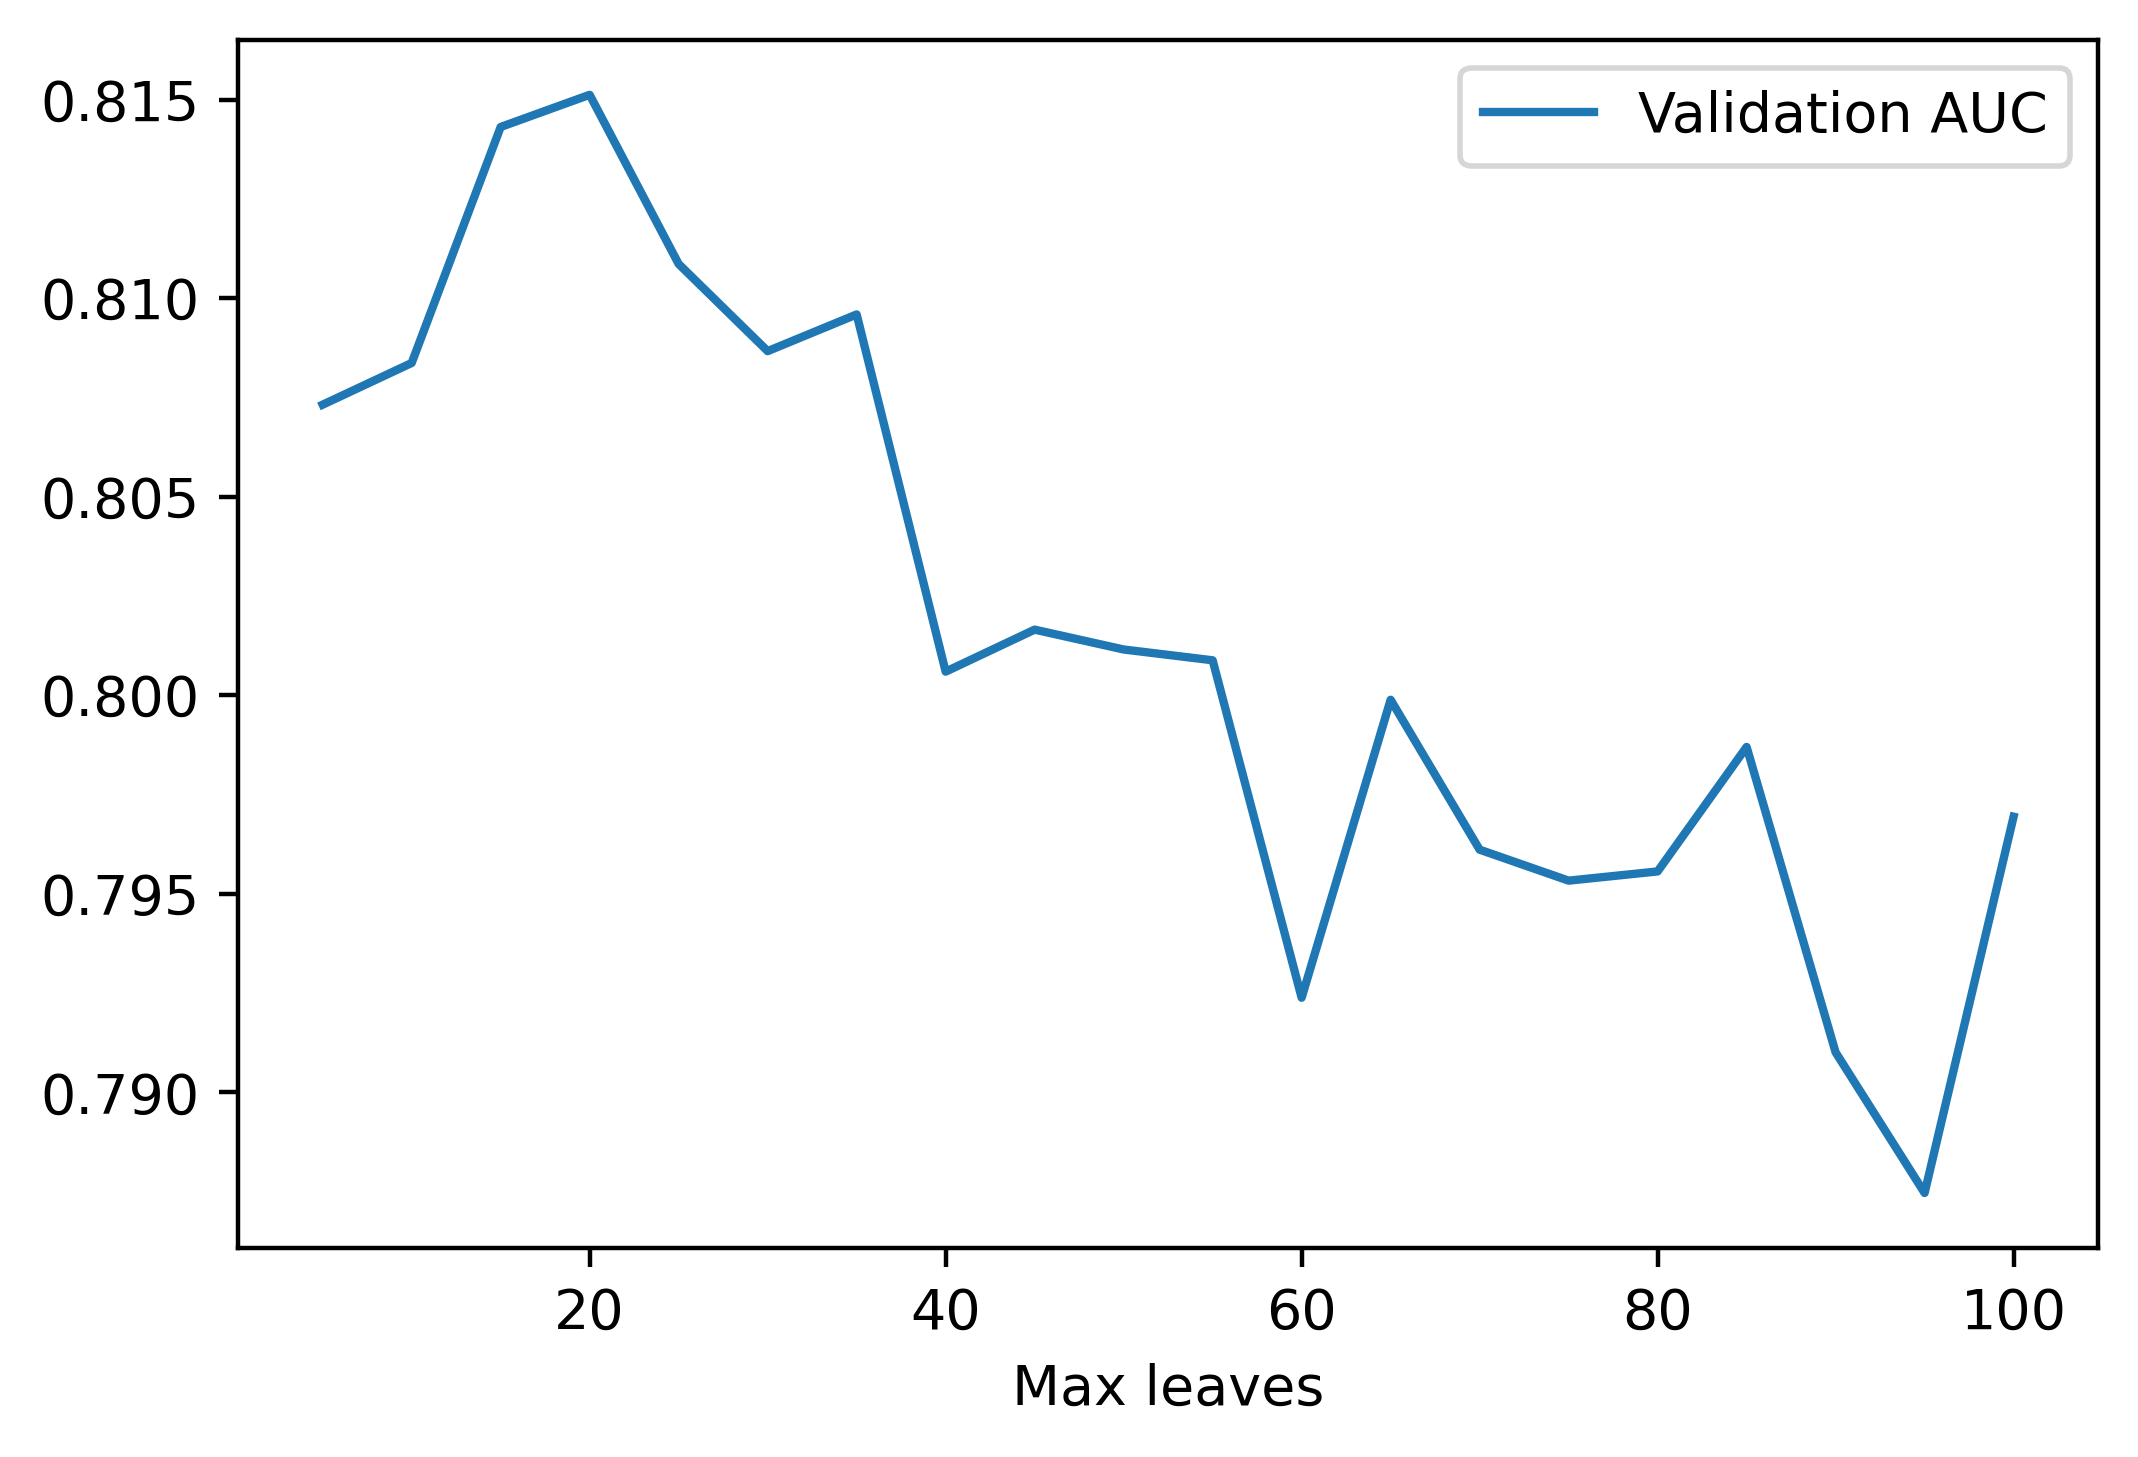

In [10]:
mpl.rcParams['figure.dpi'] = 400
max_leaves_df.set_index('Max leaves').plot()

In [11]:
max_auc = max_leaves_df['Validation AUC'].max()
max_auc
# 0.8151200989120475

0.8151200989120475

In [12]:
max_ix = max_leaves_df['Validation AUC'] == max_auc
max_leaves_df[max_ix]

,Max leaves,Validation AUC
3,20,0.81512


# SHAP values

Train model with optimal max leaves first:

In [13]:
%%time
xgb_model_3.set_params(**{'max_leaves':20})
xgb_model_3.fit(X_train, y_train, eval_set=eval_set,
              eval_metric='auc',
              verbose=False, early_stopping_rounds=30)

CPU times: user 1.88 s, sys: 170 ms, total: 2.05 s
Wall time: 1.38 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=0, max_leaves=20, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='hist',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [14]:
X_val.shape

(1000, 40)

In [15]:
feature_names = ['Feature {number}'.format(number=number)
                 for number in range(X_val.shape[1])]
X_val_df = pd.DataFrame(data=X_val, columns=feature_names)
X_val_df.head()

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,...,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
0,1.852885,-2.170293,1.057288,0.441873,-0.803131,-0.025139,-0.037143,0.037565,1.163995,0.678410,...,-0.592176,0.529113,0.923351,0.511203,-0.390155,-0.142262,0.760561,-0.421488,1.770300,-0.292780
1,-0.818316,-1.126948,0.647810,0.092433,-1.030356,0.754323,-0.351566,-0.523476,1.144878,0.219172,...,0.545090,1.125089,0.848158,-0.870549,-1.094581,-1.480010,-2.444469,0.905715,-1.008522,1.537315
2,0.020271,-0.758004,-1.136195,0.473366,1.291465,0.890423,-2.217706,-2.030749,1.768624,-2.106202,...,-0.741205,-0.833958,-0.265291,-1.021137,0.247897,-0.058583,0.445473,0.349382,0.208958,0.252826
3,-0.271543,-0.366639,-1.139614,-0.753586,1.427853,1.249856,0.060528,-0.374193,0.047770,0.640638,...,-0.539878,0.569599,0.508334,-0.513756,0.769438,1.100097,0.682759,0.888623,-0.464301,-1.125279
4,-0.549078,0.494648,-1.266778,-0.292728,1.459779,0.497898,-0.618724,-1.225373,0.171507,0.833027,...,-0.366978,-0.308615,0.838910,0.208853,2.517458,0.471553,0.982017,0.030594,0.449982,-0.670582


In [16]:
%time explainer = shap.explainers.Tree(xgb_model_3, data=X_val_df)

CPU times: user 133 ms, sys: 15.4 ms, total: 148 ms
Wall time: 108 ms


In [17]:
%time shap_values = explainer(X_val_df)

CPU times: user 1.89 s, sys: 26.9 ms, total: 1.91 s
Wall time: 2.16 s


In [18]:
shap_values

.values =
array([[-0.00638315,  0.1412218 , -0.03028931, ..., -0.00908076,
        -0.01997885, -0.27901887],
       [ 0.00922845, -0.00938471, -0.05592634, ...,  0.03525513,
         0.01730298,  0.75832271],
       [-0.00094427, -0.0110156 ,  0.03584588, ...,  0.01523119,
        -0.02357144, -0.47479338],
       ...,
       [ 0.00270036, -0.00253366, -0.04025607, ..., -0.0223883 ,
        -0.02611333, -0.30673621],
       [-0.01230153,  0.0095029 , -0.03068384, ...,  0.00167108,
        -0.02014792, -0.07814583],
       [ 0.00766691, -0.01984474,  0.00198599, ..., -0.00086327,
         0.10403682, -0.47275301]])

.base_values =
array([-0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
       -0.30949622, -0.30949622, -0.30949622, -0.30949622, -0.30949622,
 

In [19]:
shap_values.values.shape

(1000, 40)

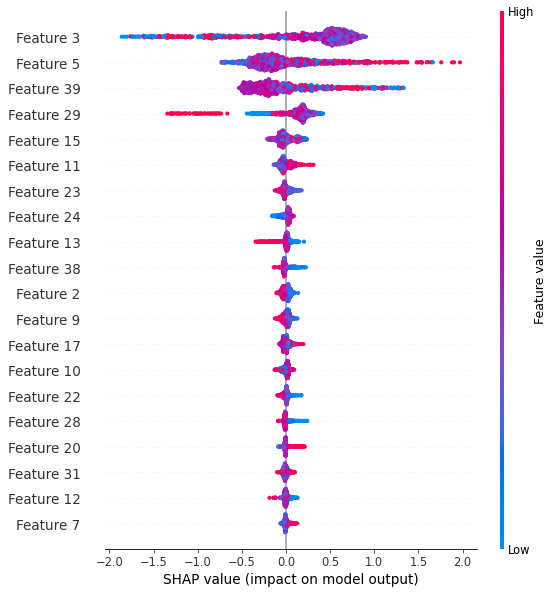

CPU times: user 1.2 s, sys: 63.6 ms, total: 1.26 s
Wall time: 1.38 s


In [20]:
%%time
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val_df)

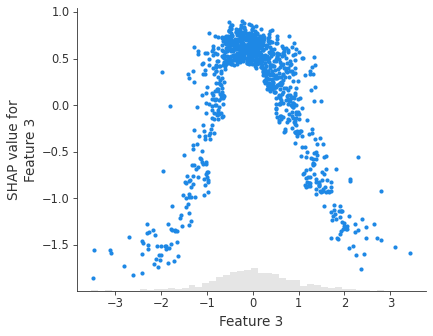

In [21]:
shap.plots.scatter(shap_values[:,'Feature 3'])

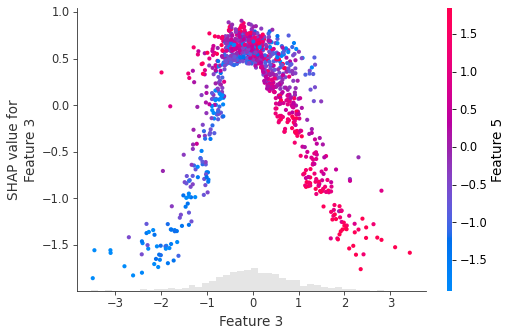

In [22]:
shap.plots.scatter(shap_values[:,'Feature 3'],
                   color=shap_values[:,'Feature 5'])

# Exercise 23

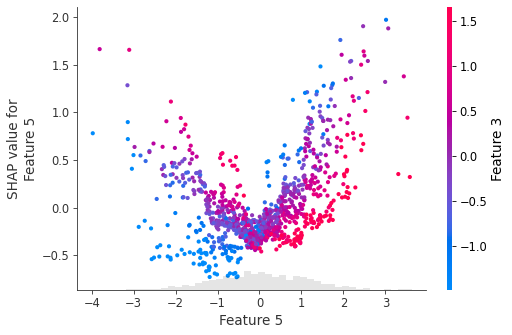

In [23]:
shap.plots.scatter(shap_values[:,'Feature 5'],
                   color=shap_values[:,'Feature 3'])

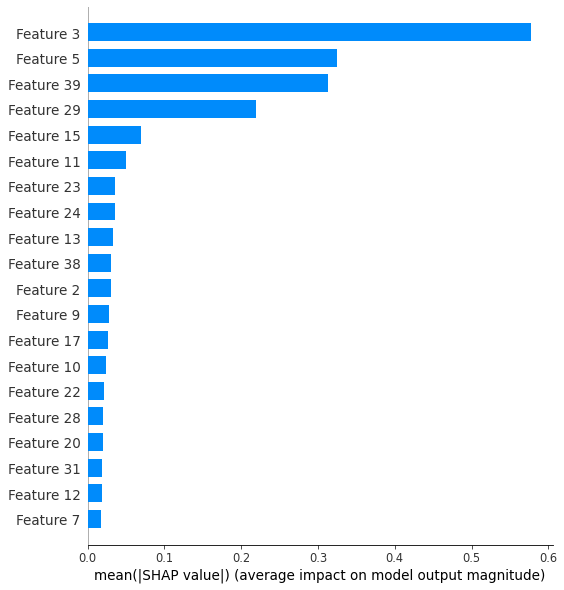

In [24]:
mpl.rcParams['figure.dpi'] = 75
shap.summary_plot(shap_values.values, X_val, plot_type='bar')

Reconstruct predict probabilities from SHAP values:

In [25]:
shap_values.values.shape

(1000, 40)

In [26]:
explainer.expected_value

-0.30949621941894295

In [27]:
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value
shap_sum.shape

(1000,)

In [28]:
shap_sum_prob = 1 / (1 + np.exp(-1 * shap_sum))

In [29]:
y_pred_proba = xgb_model_3.predict_proba(X_val)[:,1]
y_pred_proba.shape

(1000,)

In [30]:
df_check = pd.DataFrame(
    {'SHAP sum':shap_sum_prob,
     'Predicted probability':y_pred_proba})
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
507,0.497260,0.497260
818,0.466160,0.466160
452,0.881343,0.881343
368,0.145347,0.145347
242,0.481065,0.481065


In [31]:
np.allclose(df_check['SHAP sum'], df_check['Predicted probability'])

True

In [32]:
np.array_equal(df_check['SHAP sum'], df_check['Predicted probability'])

False

<AxesSubplot:xlabel='Predicted probability', ylabel='SHAP sum'>

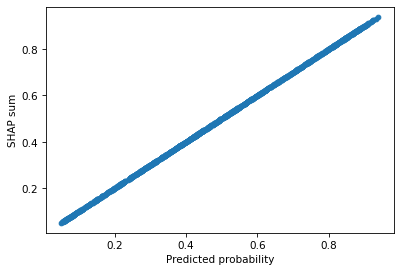

In [33]:
df_check.plot.scatter(x='Predicted probability', y='SHAP sum')